<a href="https://colab.research.google.com/github/Arindam2002/tensorflow_learning/blob/main/08_introduction_to_nlp_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP Fundamentals in TensorFlow

## Check for GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-28364eb1-2407-e0d2-08a8-55845b9bfe74)


## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/Arindam2002/tensorflow_learning/main/helper_functions.py

--2022-07-20 07:58:17--  https://raw.githubusercontent.com/Arindam2002/tensorflow_learning/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10857 (11K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.60K  --.-KB/s    in 0s      

2022-07-20 07:58:18 (76.1 MB/s) - ‘helper_functions.py’ saved [10857/10857]



In [3]:
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

## Get text dataset

We're gonna be using Kaggle's introduction to NLP dataset (text samples of Tweets labelled as diaster or not diaster).

Dataset: https://www.kaggle.com/c/nlp-getting-started

In [4]:
!pip install -q kaggle

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arindamupadhyay","key":"2f332cb7d802f0730f66d81386086181"}'}

In [6]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle competitions download -c 'nlp-getting-started'

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 19.1MB/s]


In [8]:
! unzip nlp-getting-started.zip -d nlp-getting-started

Archive:  nlp-getting-started.zip
  inflating: nlp-getting-started/sample_submission.csv  
  inflating: nlp-getting-started/test.csv  
  inflating: nlp-getting-started/train.csv  


## Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way to do so would be to use Python: https://realpython.com/read-write-files-python/

But let's get visual straight away.

So another way to do this is to use pandas...

In [9]:
import pandas as pd

train_df = pd.read_csv("/content/nlp-getting-started/train.csv")
test_df = pd.read_csv("/content/nlp-getting-started/test.csv")

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [11]:
# Check out test dataframe
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [12]:
# Number of examples of each class
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

> This is a slightly imbalanced dataset.

> In case of a highly imbalanced dataset, refer: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [13]:
# Total samples
len(train_df), len(test_df)

(7613, 3263)

In [14]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real diaster)" if target > 0 else "(not real diaster)")
  print(f"Text: {text}\n")
  print("---\n")

Target: 0 (not real diaster)
Text: I JUST SCREAMED IN 57 LANGUAGES THIS IS SO GOOD https://t.co/ldjet9tfMk

---

Target: 0 (not real diaster)
Text: Fear and panic in the air I want to be free from desolation and despair!

---

Target: 0 (not real diaster)
Text: This Friday!! Palm Beach County #Grindhouse Series one night screening of  #TexasChainsawMassacre http://t.co/1WopsGbVvv @morbidmovies

---

Target: 1 (real diaster)
Text: wowo--=== 12000 Nigerian refugees repatriated from Cameroon

---

Target: 1 (real diaster)
Text: http://t.co/pTKrXtZjtV  Nashville Theater Attack: Will Gun Grabbers Now Demand ÛÏHatchet Control?Û

---



### Split data into training and validation sets

We want to be able to see how our model is performing on unseen data whilst it trains.

And because the testing dataset doesn't have labels, we'll have to create a validation dataset to evaluate on (the model won't see the validation dataset during training so we can use its samples and labels to evaluate our model's performance).

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
# Use train_test_split to split the training data into training & validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,    # use 10% of training data for validation split
                                                                            random_state=42)

In [17]:
# Check lengths of new datasets
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [18]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers

When dealing with a text problem, one of the first things we have to do before we can build a model is to convert our text to numbers.

There are a few ways to do this, namely:
* Tokenziation - direct mapping of token (a token could be a word or a character) to number
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

### Text vectorization (tokenization)

In [19]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [20]:
from pandas.core.common import standardize_mapping
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None,   # how many words in the vocabulary (automatically add <OOV>)
                                     standardize="lower_and_strip_punctuation",   # how to process text
                                     split="whitespace",    # how to split tokens
                                     ngrams=None,   # create groups of n-words
                                     output_mode="int",   # how to map tokens to numbers
                                     output_sequence_length=None,   # how long should the output sequence of tokens be?
                                    #  pad_to_max_tokens=True   # Not valid if using max_tokens=None
                                     )

In [21]:
len(train_sentences[0].split())

7

In [22]:
# Find the avg number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [23]:
# Setup text vectorization variables
max_vocab_length = 10000    # max number of words to have in our vocabulary
max_length = 15   # max length our sequences will be (e.g. how many words from a Tweet does a model see?)


text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [24]:
# Fit the text vectorizer to training text
text_vectorizer.adapt(train_sentences)

In [25]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [26]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence} \
        \n\nVectorized version: \n{text_vectorizer([random_sentence])}")

Original text:
@_chelsdelong12 @kendra_leigh13 I'll crash it         

Vectorized version: 
[[  1   1 421  85  15   0   0   0   0   0   0   0   0   0   0]]


In [27]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()   # Get all the unique words in our training data
top_5_words = words_in_vocab[:5]                    # the most common words in the vocab
bottom_5_words = words_in_vocab[-5:]                # the least common words in the vocab
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Most 5 common words in vocab: {top_5_words}")
print(f"Least 5 common words in vocab: {bottom_5_words}")

Number of words in vocab: 10000
Most 5 common words in vocab: ['', '[UNK]', 'the', 'a', 'in']
Least 5 common words in vocab: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


## Creating an Embedding using an Embedding Layer

    Turns positive integers (indexes) into dense vectors of fixed size

[`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)

The main parameters we're concerned about here are:
* `input_dim` - The size of the vocabulary (e.g. `len(text_vectorizer.get_vocabulary()`).
* `output_dim` - The size of the output embedding vector, for example, a value of `100` outputs a  feature vector of size 100 for each word.
* `embeddings_initializer` - How to initialize the embeddings matrix, default is `"uniform"` which randomly initalizes embedding matrix with uniform distribution and modifies itself as the model trains. This can be changed for using pre-learned embeddings.
* `input_length` - Length of sequences being passed to embedding layer.

In [28]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,    # Prefer a multiple of 8 for faster computation
                             embeddings_initializer="uniform",
                             input_length=max_length)

embedding

In [29]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence} \
        \n\nEmbedded version:")

# Embed the random sentence (turn it into dense vectors of fixed size)...
# First we gotta turn our sentence into integer form since embedding layer Turns positive integers (indexes) into dense vectors of fixed size
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
@olrules Welcome - Read a free chapter of my new book Encounters With Jesus. It's full of hope. http://t.co/6qX7arf4AG         

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.0292994 , -0.0291266 , -0.03911811, ...,  0.00065811,
         -0.04494727,  0.00993083],
        [-0.04124365, -0.01828172,  0.00555946, ...,  0.02010162,
         -0.00851266,  0.02548548],
        [ 0.02467858,  0.00598794,  0.01228527, ...,  0.04410759,
         -0.02241321,  0.00102876],
        ...,
        [ 0.02970538, -0.045256  ,  0.03756801, ..., -0.00240166,
         -0.03264445, -0.01893859],
        [-0.02345494,  0.00255754,  0.00564493, ...,  0.02866813,
          0.01739612,  0.03217764],
        [ 0.0149958 ,  0.03080846, -0.00451688, ..., -0.00737882,
          0.01325226,  0.02621965]]], dtype=float32)>

In [30]:
# Check out a single token's embedding (first word of the random sentence)
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.0292994 , -0.0291266 , -0.03911811, -0.0162711 , -0.03821252,
         0.04943268,  0.04634644, -0.04111554, -0.01783438,  0.03181769,
        -0.0469859 , -0.01796906, -0.02213192, -0.03415477, -0.04163855,
         0.044303  , -0.04164295, -0.01372989,  0.03119539, -0.01794648,
         0.01814151,  0.04700426, -0.00786752, -0.03900969, -0.003588  ,
         0.02873996, -0.00596328,  0.01523087, -0.03659713,  0.04747016,
        -0.016645  , -0.03871424, -0.04469598,  0.01231394,  0.01007832,
         0.00946035, -0.02571931, -0.01919539,  0.0403966 ,  0.0272916 ,
        -0.04900105,  0.02550776, -0.00673159,  0.04216984,  0.02358594,
         0.03150092, -0.01818534,  0.04349276,  0.01350049,  0.03010071,
         0.04803336,  0.03884185, -0.01543299, -0.04829922, -0.02768956,
        -0.04935468, -0.0067266 ,  0.03330794,  0.01507351, -0.00637012,
         0.01790548,  0.01630897, -0.00526017, -0.01110787,  0.04629321,
  

## Modelling a text dataset (setting up modelling experiments)

Now we've got our data in numerical format, let's start building and comparing different models.

* Model 0: Naive Bayes (baseline) - got this from here: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model
* Model 3: GRU model
* Model 4: Bidirectional LSTM
* Model 5: 1D Convolutional Neural Network
* Model 6: TensorFlow Hub Pretrained Word Embedding (feature extractor)
* Model 7: Same as model 6 but using 10% of data

For each of these models, we're going to be following the TensorFlow steps in modelling:
* Create a model
* Fit the model
* Make predictions with the model
* Track prediction evaluation metrics for later comparison

### Model 0: Getting a baseline

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using the TF-IDF formula to convert our words to numbers.

> **Note:** It's common practice to use non-DL algorithms as a baseline because of their speed & then later using DL to see if we can improve upon them.


In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()),   # convert words to numbers using tfidf
                    ('clf', MultinomialNB())        # model the text
])

# Fit the pipeline to training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [32]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [33]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments

Let's create a function to evaluate our modelling experiment predictions using: 
* Accuracy
* Precision
* Recall
* F1-score

In [34]:
# Function to evaluate: accuracy, precision, recall, F1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  ----
  y_true = true labels in the form of a 1D array
  y_pred = predicted label in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall and f1-score between y_true and y_pred.
  """

  # Calculate model accuracy 
  model_accuracy = accuracy_score(y_true, y_pred) * 100

  # Calculate model precision, recall & f1 score using weighted averag
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

  # Create a dictionary of model results
  model_results = {
      "accuracy": model_accuracy,
      "precision": model_precision,
      "recall": model_recall,
      "f1": model_f1
  }

  return model_results

In [35]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 1: A simple dense model

In [36]:
# Create a tensorboard callback (nned to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save tensorboard logs
SAVE_DIR = "model_logs"

In [37]:
# Build model with the Functional API
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)    # inputs are 1-dimensional strings
x = text_vectorizer(inputs)   # turn the input text into numbers
x = embedding(x)    # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x)    # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(units=1, activation="sigmoid")(x)    # Create the output layer (since binary outputs, use sigmoid activation function)

model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

Great! Our model takes a 1-dimensional string as input (in our case, a Tweet), it then tokenizes the string using `text_vectorizer` and creates an embedding using `embedding`.

We then pool the outputs of the embedding layer to reduce the dimensionality of the tensor we pass to the output layer. (**Note:** This is necessary to match output dimension of our network with label dimension...We can use `GlobalAveragePooling1D()`, `GlobalAveragePooling2D()` or `GlobalAveragePooling3D()` depending on the data shape.)

Finally, we pass the output of the pooling layer to a dense layer with sigmoid activation (we use sigmoid since our problem is binary classification).

Before we can fit our model to the data, we've got to compile it. Since we're working with binary classification, we'll use `"binary_crossentropy"` as our loss function and the Adam optimizer.

In [38]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [39]:
# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [40]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20220720-075841
Epoch 1/5
215/215 [==============================] - 7s 9ms/step - loss: 0.6113 - accuracy: 0.6981 - val_loss: 0.5411 - val_accuracy: 0.7454
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.4427 - accuracy: 0.8180 - val_loss: 0.4713 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3467 - accuracy: 0.8591 - val_loss: 0.4584 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2850 - accuracy: 0.8898 - val_loss: 0.4605 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2380 - accuracy: 0.9114 - val_loss: 0.4780 - val_accuracy: 0.7835


In [41]:
# Evaluate the model
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 5ms/step - loss: 0.4780 - accuracy: 0.7835


[0.47796574234962463, 0.7834645509719849]

In [42]:
# Make a few predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[0], val_sentences[0]

(array([0.41853407], dtype=float32),
 'DFR EP016 Monthly Meltdown - On Dnbheaven 2015.08.06 http://t.co/EjKRf8N8A8 #Drum and Bass #heavy #nasty http://t.co/SPHWE6wFI5')

In [43]:
# Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [44]:
# Calculate our model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.34645669291339,
 'f1': 0.7807800582578167,
 'precision': 0.7872123378365872,
 'recall': 0.7834645669291339}

In [45]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Visualizing learned embeddings

To further understand word embeddings, let's visualize them, to do so, we'll get the weights matrix (embedding matrix) from our embedding layer and visualize it using the Embedding project tool, see the TensorFlow guide for more: https://www.tensorflow.org/tutorials/text/word_embeddings

In [46]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [47]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [48]:
# Get the weight matrix of embeddig layer
# (the weights are the numerical patterns between the text in the training dataset that the model has learned)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
embed_weights.shape   # same size as vocab size and embedding_dim (output_dim of our embedding layer)

(10000, 128)

> Now we've got the embedding matrix our model has learned to represent our tokens... Let's see how we can visualize it.

> To do so, TensorFlow has a handy tool called projector: https://projector.tensorflow.org/

> And TensorFlow also has an incredible guide on word embeddings themselves: https://www.tensorflow.org/tutorials/text/word_embeddings

In [49]:
import io

# Code to save trained embeddings to file - we got this from here: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [50]:
# Download files from colab to upload to projector
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Our visual word embeddings might not look like much to us, but they help our model understand the relationships between words.

For more on a popular type of word embedding and more visual explanations check out the illustrated word2vec: https://jalammar.github.io/illustrated-word2vec/

## Recurrent Neural Networks (RNN's)

For our next series of modelling experiments we're going to be using a special kind of neural network called a **Recurrent Neural Network (RNN)**.

>***The premise of an RNN is to use the representation of a previous input to aid the representation of a later input***

The premise of an RNN is simple: use information from the past to help you with the future (this is where the term recurrent comes from). In other words, take an input (`X`) and compute an output (`y`) based on all previous inputs.

This concept is especially helpful when dealing with sequences such as passages of natural language text (such as our Tweets).

For example, when you read this sentence, you take into context the previous words when deciphering the meaning of the current word dog. 

See what happened there? 

I put the word "dog" at the end which is a valid word but it doesn't make sense in the context of the rest of the sentence.

When an RNN looks at a sequence of text (already in numerical form), the patterns it learns are continually updated based on the order of the sequence. 

For a simple example, take two sentences:
1. Massive earthquake last week, no?
2. No massive earthquake last week.

Both contain exactly the same words but have different meaning. The order of the words determines the meaning (one could argue punctuation marks also dictate the meaning but for simplicity sake, let's stay focused on the words).

Recurrent neural networks can be used for a number of sequence-based problems:
* **One to one:** one input, one output, such as image classification.
* **One to many:** one input, many outputs, such as image captioning (image input, a sequence of text as caption output).
* **Many to one:** many inputs, one outputs, such as text classification (classifying a Tweet as real diaster or not real diaster).
* **Many to many:** many inputs, many outputs, such as machine translation (translating English to Spanish) or speech to text (audio wave as input, text as output).

When you come across RNN's in the wild, you'll most likely come across variants of the following:
* Long short-term memory cells (LSTMs).
* Gated recurrent units (GRUs).
* Bidirectional RNN's (passes forward and backward along a sequence, left to right and right to left).

Going into the details of each these is beyond the scope of this notebook (we're going to focus on using them instead), the main thing you should know for now is that they've proven very effective at modelling sequences.

For a deeper understanding of what's happening behind the scenes of the code we're about to write, I'd recommend the following resources:

> 📖 **Resources:**
> * [MIT Deep Learning Lecture on Recurrent Neural Networks](https://youtu.be/SEnXr6v2ifU) - explains the background of recurrent neural networks and introduces LSTMs.
> * [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) by Andrej Karpathy - demonstrates the power of RNN's with examples generating various sequences.
> * [Understanding LSTMs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) by Chris Olah - an in-depth (and technical) look at the mechanics of the LSTM cell, possibly the most popular RNN building block.


### Model 2: LSTM

With all this talk of what RNN's are and what they're good for, I'm sure you're eager to build one.

We're going to start with an LSTM-powered RNN.

To harness the power of the LSTM cell (LSTM cell and LSTM layer are often used interchangably) in TensorFlow, we'll use [`tensorflow.keras.layers.LSTM()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM).

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-RNN-architecture-coloured-block-edition.png)
*Coloured block example of the structure of an recurrent neural network.*

Our model is going to take on a very similar structure to `model_1`:

```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```

The main difference will be that we're going to add an LSTM layer between our embedding and output.

And to make sure we're not getting reusing trained embeddings (this would involve data leakage between models, leading to an uneven comparison later on), we'll create another embedding layer (`model_2_embedding`) for our model. The `text_vectorizer` layer can be reused since it doesn't get updated during training.

> 🔑 **Note:** The reason we use a new embedding layer for each model is since the embedding layer is a *learned* representation of words (as numbers), if we were to use the same embedding layer (`embedding_1`) for each model, we'd be mixing what one model learned with the next. And because we want to compare our models later on, starting them with their own embedding layer each time is a better idea.

In [51]:
# Create an LSTM model
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(units=64, return_sequences=True)(x)   # when we're stacking RNN cells together, we need to set return_sequences = True
# print(x.shape)
x = layers.LSTM(units=64)(x)
# print(x.shape)
# x = layers.Dense(units=64, activation="relu")(x)
# print(x.shape)
outputs = layers.Dense(units=1, activation="sigmoid")(x)

model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [52]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [53]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [54]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20220720-075908
Epoch 1/5
215/215 [==============================] - 9s 8ms/step - loss: 0.2234 - accuracy: 0.9232 - val_loss: 0.5437 - val_accuracy: 0.7874
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1587 - accuracy: 0.9445 - val_loss: 0.6344 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1274 - accuracy: 0.9502 - val_loss: 0.6781 - val_accuracy: 0.7822
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1065 - accuracy: 0.9575 - val_loss: 0.7726 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0891 - accuracy: 0.9660 - val_loss: 0.8443 - val_accuracy: 0.7756


In [55]:
# Make prdictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[6.4937216e-03],
       [8.6211991e-01],
       [9.9953640e-01],
       [3.3078786e-02],
       [5.6151405e-04],
       [9.6289885e-01],
       [4.8877928e-01],
       [9.9955863e-01],
       [9.9910468e-01],
       [5.4922515e-01]], dtype=float32)

In [56]:
# Convert model_2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 1.], dtype=float32)>

In [57]:
# Calculate model_2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.55905511811024,
 'f1': 0.7720383798735819,
 'precision': 0.7810725814480683,
 'recall': 0.7755905511811023}

In [58]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.

The architecture of the GRU-powered model will follow the same structure we've been using:

```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```

Again, the only difference will be the layer(s) we use between the embedding and the output.


In [59]:
# Build an RNN using GRU cell
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(units=64)(x)
# print(x.shape)
# x = layers.GRU(units=64, return_sequences=True)(x)   # when we're stacking RNN cells together, we need to set return_sequences = True
# print(x.shape)
# x = layers.LSTM(units=64, return_sequences=True)(x)
# print(x.shape)
# x = layers.GRU(units=64)(x)
# print(x.shape)
# x = layers.Dense(units=64, activation="relu")(x)

outputs = layers.Dense(units=1, activation="sigmoid")(x)

model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [60]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [61]:
# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [62]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20220720-075923
Epoch 1/5
215/215 [==============================] - 3s 8ms/step - loss: 0.1526 - accuracy: 0.9418 - val_loss: 0.7339 - val_accuracy: 0.7717
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0849 - accuracy: 0.9701 - val_loss: 0.9432 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0725 - accuracy: 0.9727 - val_loss: 0.9798 - val_accuracy: 0.7625
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0651 - accuracy: 0.9753 - val_loss: 0.9155 - val_accuracy: 0.7625
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0604 - accuracy: 0.9759 - val_loss: 0.9463 - val_accuracy: 0.7690


In [63]:
# Make some predictions with our GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

array([[2.5349235e-02],
       [9.6070325e-01],
       [9.9958271e-01],
       [5.1773131e-02],
       [1.7986345e-04],
       [9.9679464e-01],
       [1.1854186e-01],
       [9.9986303e-01],
       [9.9974984e-01],
       [7.3245078e-01]], dtype=float32)

In [64]:
# Convert model_3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 1.], dtype=float32)>

In [65]:
# Calculate model_3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 76.9028871391076,
 'f1': 0.7665280970313494,
 'precision': 0.7714293151588276,
 'recall': 0.7690288713910761}

In [66]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [67]:
print('bleh')

bleh


### Model 4: Bidirectional RNN model

[`tf.keras.layers.Bidirectional`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional)

A standard RNN will process a sequence from left to right, where as a bidirectional RNN will process the sequence from left to right and then again from right to left.

> 🔑 **Note:** You can use the `Bidirectional` wrapper on any RNN cell in TensorFlow. For example, `layers.Bidirectional(layers.GRU(64))` creates a bidirectional GRU cell.

In [68]:
# Build a bidirectional RNN
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.Bidirectional(layers.LSTM(units=64, return_sequences=True))(x)
# print(x.shape)
x = layers.Bidirectional(layers.LSTM(units=64))(x)
# print(x.shape)

outputs = layers.Dense(units=1, activation="sigmoid")(x)

model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [69]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [70]:
# Compile the model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [71]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20220720-075933
Epoch 1/5
215/215 [==============================] - 5s 11ms/step - loss: 0.1088 - accuracy: 0.9686 - val_loss: 0.9298 - val_accuracy: 0.7625
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0547 - accuracy: 0.9781 - val_loss: 1.2309 - val_accuracy: 0.7625
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0488 - accuracy: 0.9791 - val_loss: 1.3381 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0428 - accuracy: 0.9813 - val_loss: 1.3051 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0446 - accuracy: 0.9794 - val_loss: 1.2704 - val_accuracy: 0.7717


In [72]:
# Make predictions with our bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[1.4142737e-03],
       [8.6668682e-01],
       [9.9996686e-01],
       [2.9042989e-02],
       [8.3620580e-05],
       [9.9917608e-01],
       [1.3575248e-03],
       [9.9998879e-01],
       [9.9998283e-01],
       [7.4255532e-01]], dtype=float32)

In [73]:
# Convert model_4 pred probs into labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 1.], dtype=float32)>

In [74]:
# Calculate model_4 results
model_4_results = calculate_results(y_true=val_labels,
                  y_pred=model_4_preds)
model_4_results

{'accuracy': 77.16535433070865,
 'f1': 0.7688960790251899,
 'precision': 0.7747861668850706,
 'recall': 0.7716535433070866}

In [75]:
model_3_results

{'accuracy': 76.9028871391076,
 'f1': 0.7665280970313494,
 'precision': 0.7714293151588276,
 'recall': 0.7690288713910761}

## Convolutional Neural Networks for Text (and other types of sequences)

The main difference between using CNNs for images and sequences is the shape of the data. Images come in 2-dimensions (height x width) where as sequences are often 1-dimensional (a string of text).

So to use CNNs with sequences, we use a 1-dimensional convolution instead of a 2-dimensional convolution.

A typical CNN architecture for sequences will look like the following: 

```
Inputs (text) -> Tokenization -> Embedding -> Layers (typically Conv1D + pooling) -> Outputs (class probabilities)
```

You might be thinking "that just looks like the architecture layout we've been using for the other models..."

And you'd be right.

The difference again is in the layers component. Instead of using an LSTM or GRU cell, we're going to use a [`tensorflow.keras.layers.Conv1D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) layer followed by a [`tensorflow.keras.layers.GlobablMaxPool1D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D) layer.

> 📖 **Resource:** The intuition here is explained succinctly in the paper [*Understanding Convolutional Neural Networks for Text Classification*](https://www.aclweb.org/anthology/W18-5408.pdf), where they state that CNNs classify text through the following steps:
1. 1-dimensional convolving filters are used as ngram detectors, each filter specializing in a closely-related family of ngrams (an ngram is a collection of n-words, for example, an ngram of 5 might result in "hello, my name is Daniel").
2. Max-pooling over time extracts the relevant ngrams for making a decision.
3. The rest of the network classifies the text based on this information.

### Model 5: Conv1D

In [76]:
# Test out our embedding layer, Conv1D layer and max pooling
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(["this is a test sentence"]))    # turn target sequence into embedding
conv_1d = layers.Conv1D(filters=64,
                        kernel_size=5,    # aka ngram of 5 (i.e. looks at 5 words at a time)
                        strides=1,        # default
                        activation="relu",
                        padding="same")  # default = 'valid', the output shape is smaller than the input shape... 'same' means output shape is same as the input shape
conv_1d_output = conv_1d(embedding_test)    # pass test embedding through conv_1d layer
max_pool = layers.GlobalMaxPooling1D()
max_pool_output = max_pool(conv_1d_output)  # equivalent to "get the most important feature" or "get the feature with highest value"

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 15, 64]), TensorShape([1, 64]))

> **NOTE:** ***'same' and 'valid' padding difference:***
[stackoverflow answer](https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t#:~:text=To%20sum%20up%2C%20'valid',same'%20padding%20means%20using%20padding.)

In [77]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.00767935, -0.08610959,  0.01838144, ..., -0.04509318,
         -0.03022609, -0.07111328],
        [-0.01852835, -0.01851673,  0.03740028, ..., -0.03926198,
          0.0237287 ,  0.01528002],
        [ 0.04817761, -0.05787547, -0.01110806, ..., -0.04036497,
         -0.07805195, -0.0361486 ],
        ...,
        [ 0.00887255,  0.00051377,  0.02100966, ...,  0.0082314 ,
         -0.02989312,  0.00505195],
        [ 0.00887255,  0.00051377,  0.02100966, ...,  0.0082314 ,
         -0.02989312,  0.00505195],
        [ 0.00887255,  0.00051377,  0.02100966, ...,  0.0082314 ,
         -0.02989312,  0.00505195]]], dtype=float32)>

In [78]:
conv_1d_output

<tf.Tensor: shape=(1, 15, 64), dtype=float32, numpy=
array([[[0.01596651, 0.        , 0.        , 0.        , 0.02815423,
         0.05527361, 0.02786904, 0.        , 0.04469164, 0.        ,
         0.03332338, 0.05359464, 0.        , 0.02467459, 0.01003791,
         0.01805171, 0.        , 0.        , 0.01027194, 0.        ,
         0.0669373 , 0.        , 0.        , 0.02556402, 0.01759217,
         0.02698524, 0.04963886, 0.02309605, 0.03871229, 0.07257203,
         0.        , 0.03836748, 0.        , 0.        , 0.06185272,
         0.        , 0.05550434, 0.00264016, 0.00886428, 0.00497754,
         0.00424889, 0.00039165, 0.03421456, 0.        , 0.        ,
         0.00251929, 0.06149445, 0.01276842, 0.        , 0.        ,
         0.        , 0.        , 0.05182439, 0.00193843, 0.        ,
         0.00186551, 0.        , 0.        , 0.0261021 , 0.04502288,
         0.03871666, 0.        , 0.        , 0.        ],
        [0.04261844, 0.        , 0.        , 0.        , 0.  

In [79]:
max_pool_output

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[0.04261844, 0.04674674, 0.01167733, 0.04187524, 0.02815423,
        0.05527361, 0.04535618, 0.07332428, 0.04469164, 0.01819955,
        0.12309861, 0.05359464, 0.0725013 , 0.0327512 , 0.06520073,
        0.0412107 , 0.0233355 , 0.04094567, 0.04286645, 0.06228843,
        0.0669373 , 0.03969556, 0.05469438, 0.08045674, 0.07429171,
        0.02698524, 0.04963886, 0.05087449, 0.03871229, 0.09142193,
        0.        , 0.06968398, 0.04611164, 0.        , 0.0994173 ,
        0.06534915, 0.05550434, 0.04282183, 0.08229512, 0.00497754,
        0.06005473, 0.07002001, 0.05858637, 0.01464803, 0.03074409,
        0.01922715, 0.06149445, 0.0335321 , 0.05941134, 0.05485136,
        0.01982999, 0.01313843, 0.05182439, 0.04312146, 0.01028004,
        0.0303507 , 0.05229007, 0.09892935, 0.03019245, 0.07524598,
        0.0468313 , 0.0618264 , 0.04113546, 0.06866144]], dtype=float32)>

In [80]:
# Create 1-dimensional CNN to model sequences
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(units=64, activation="relu")(x)

outputs = layers.Dense(units=1, activation="sigmoid")(x)

model_5 = tf.keras.Model(inputs, outputs, name="model_5_conv1d")

In [81]:
model_5.summary()

Model: "model_5_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [82]:
# Compile the model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [83]:
# Fit the model
BATCH_SIZE = 32
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              batch_size=32,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_5_conv1d")])

Saving TensorBoard log files to: model_logs/model_5_conv1d/20220720-075953
Epoch 1/5
215/215 [==============================] - 3s 6ms/step - loss: 0.1214 - accuracy: 0.9566 - val_loss: 0.9318 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0730 - accuracy: 0.9733 - val_loss: 1.0762 - val_accuracy: 0.7638
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0616 - accuracy: 0.9753 - val_loss: 1.1747 - val_accuracy: 0.7559
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0554 - accuracy: 0.9765 - val_loss: 1.2757 - val_accuracy: 0.7625
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0504 - accuracy: 0.9783 - val_loss: 1.2585 - val_accuracy: 0.7507


In [84]:
# Make predictions
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[4.9295482e-01],
       [1.7571048e-01],
       [9.9988425e-01],
       [3.3408999e-02],
       [1.4816068e-08],
       [9.9773860e-01],
       [9.5493472e-01],
       [9.9993610e-01],
       [9.9999988e-01],
       [8.8120055e-01]], dtype=float32)

In [85]:
# Convert model_5 pred probs into labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [86]:
# Calculate the results of model_5
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 75.06561679790026,
 'f1': 0.7487994714665389,
 'precision': 0.7511704709318223,
 'recall': 0.7506561679790026}

In [87]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

## Model 6: TensorFlow Hub Pretrained Sentence Encoder

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-USE-tensorflow-hub-encoder-decoder-model.png)
*The feature extractor model we're building through the eyes of an **encoder/decoder** model.*

**Refer:** https://tfhub.dev/google/universal-sentence-encoder/4

In [88]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       "Potato patato pleh phew"])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [89]:
embed_samples

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[-0.01157028,  0.0248591 ,  0.02878048, ..., -0.00186124,
         0.02315826, -0.01485021],
       [ 0.00136726,  0.04412336,  0.04159484, ..., -0.03636198,
         0.0215806 , -0.00588427]], dtype=float32)>

In [90]:
embed_samples[0].shape

TensorShape([512])

In [91]:
# Create a keras layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [92]:
# Create model using sequential API
from tensorflow.keras import layers

model_6 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(units=64, activation="relu"),
  layers.Dense(units=1, activation="sigmoid", name="output_layer"),
], name="model_6_USE")

In [93]:
# Compile the model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [94]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [95]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_6_USE")])

Saving TensorBoard log files to: model_logs/model_6_USE/20220720-080019
Epoch 1/5
215/215 [==============================] - 5s 13ms/step - loss: 0.5077 - accuracy: 0.7872 - val_loss: 0.4527 - val_accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4163 - accuracy: 0.8130 - val_loss: 0.4391 - val_accuracy: 0.8045
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4018 - accuracy: 0.8221 - val_loss: 0.4387 - val_accuracy: 0.8097
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.3935 - accuracy: 0.8262 - val_loss: 0.4348 - val_accuracy: 0.8071
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3879 - accuracy: 0.8295 - val_loss: 0.4268 - val_accuracy: 0.8163


In [96]:
# Make predictions with USE TF Hub Model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.20007166],
       [0.7766229 ],
       [0.984145  ],
       [0.20315126],
       [0.75567925],
       [0.7253024 ],
       [0.97658384],
       [0.9755408 ],
       [0.9235462 ],
       [0.11363076]], dtype=float32)

In [97]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [98]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 81.62729658792651,
 'f1': 0.8149048737121865,
 'precision': 0.8181574920275534,
 'recall': 0.8162729658792651}

In [99]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

## Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning really helps when we don't have a large dataset.

To see how our model performs on a smaller dataset, let's replicate `model_6` except we'll train it on 10% of the data.

> 🔑 **Note:** Be *very* careful when creating training/val/test splits that you don't leak data across the datasets, otherwise your model evaluation metrics will be wrong. If something looks too good to be true (a model trained on 10% of data outperforming the same model trained on 100% of data) trust your gut and go back through to find where the error may lie.

In [100]:
# ## NOTE: Making data splits like below leads to data leakage (model_7 trained on 10% data, outperforms model_6 trained on 100% data)
# ## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SET 

# # Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)

# # train_10_percent.head(), len(train_10_percent)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()

# len(train_sentences_10_percent), len(train_labels_10_percent)

In [101]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [102]:
# Check the number of each label in the updated training data subset
import numpy as np
import pandas as pd

pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [103]:
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

> To recreate a model the same as a previous model we've created, we can use the `tf.keras.models.clone_model()` method, see more here: https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model

In [104]:
# Let's build a model the same as model_6
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [105]:
# Fit the model to the 10% training data subsets
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder_10_percent_correct_split")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20220720-080045
Epoch 1/5
22/22 [==============================] - 5s 55ms/step - loss: 0.6717 - accuracy: 0.6438 - val_loss: 0.6509 - val_accuracy: 0.7244
Epoch 2/5
22/22 [==============================] - 1s 25ms/step - loss: 0.5995 - accuracy: 0.8029 - val_loss: 0.5905 - val_accuracy: 0.7743
Epoch 3/5
22/22 [==============================] - 1s 26ms/step - loss: 0.5219 - accuracy: 0.8088 - val_loss: 0.5331 - val_accuracy: 0.7743
Epoch 4/5
22/22 [==============================] - 1s 25ms/step - loss: 0.4598 - accuracy: 0.8219 - val_loss: 0.5026 - val_accuracy: 0.7782
Epoch 5/5
22/22 [==============================] - 0s 20ms/step - loss: 0.4198 - accuracy: 0.8307 - val_loss: 0.4904 - val_accuracy: 0.7861


In [106]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.20228526],
       [0.59397286],
       [0.92162156],
       [0.40631747],
       [0.5329078 ],
       [0.67895025],
       [0.8896933 ],
       [0.7919374 ],
       [0.85356516],
       [0.16019765]], dtype=float32)

In [107]:
# Turn pred probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [108]:
# Evalaute model 7 predictions
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 78.60892388451444,
 'f1': 0.7845514310000248,
 'precision': 0.7872311306036273,
 'recall': 0.7860892388451444}

In [109]:
model_6_results

{'accuracy': 81.62729658792651,
 'f1': 0.8149048737121865,
 'precision': 0.8181574920275534,
 'recall': 0.8162729658792651}

## Comparing the peformance of each of our models

In [110]:
# Combine model results into a DataFrame
import pandas as pd

all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_hub_use_encoder_10_percent": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,78.346457,0.787212,0.783465,0.780780
2_lstm,77.559055,0.781073,0.775591,0.772038
3_gru,76.902887,0.771429,0.769029,0.766528
4_bidirectional,77.165354,0.774786,0.771654,0.768896
5_conv1d,75.065617,0.751170,0.750656,0.748799
6_tf_hub_use_encoder,81.627297,0.818157,0.816273,0.814905
7_tf_hub_use_encoder_10_percent,78.608924,0.787231,0.786089,0.784551


In [111]:
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.783465,0.787212,0.783465,0.780780
2_lstm,0.775591,0.781073,0.775591,0.772038
3_gru,0.769029,0.771429,0.769029,0.766528
4_bidirectional,0.771654,0.774786,0.771654,0.768896
5_conv1d,0.750656,0.751170,0.750656,0.748799
6_tf_hub_use_encoder,0.816273,0.818157,0.816273,0.814905
7_tf_hub_use_encoder_10_percent,0.786089,0.787231,0.786089,0.784551


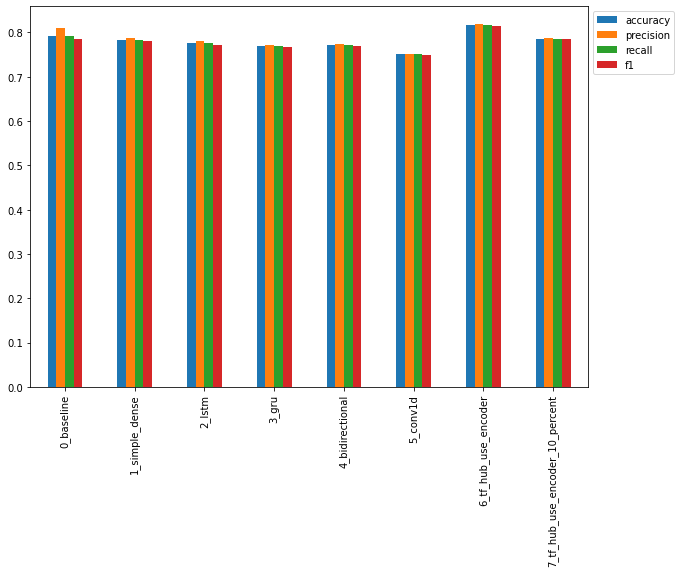

In [112]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

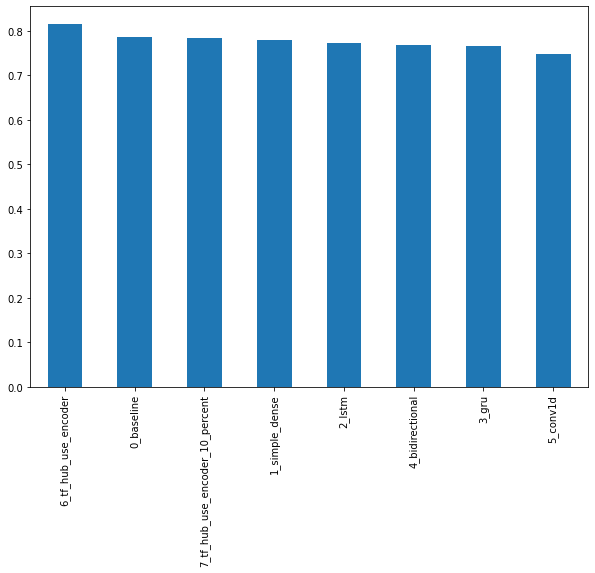

In [113]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

## Uploading our model training logs to TesnorBoard.dev
We can further inspect our model's performance using TensorBoard.dev: https://tensorboard.dev/

In [114]:
# View TensorBoard logs of transfer learning modelling experiments (plus all of our other models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./model_logs/ \
  --name "NLP Modelling Experiments" \
  --description "Comparing multiple different types of model architectures on the Kaggle Tweets text classification dataset" \
  --one_shot    # exit the uploader once uploading is finished


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_logs/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=Op5B0Dth8pW3d9Q5blcBwLFW77v2CT&prompt=consent&access_type=offline

> For larger scale experiments and a whole bunch more tracking options, check out Weights & Biases: https://wandb.ai/site

In [115]:
# Previous TensorBoard Dev experiments we've run...
!tensorboard dev list

https://tensorboard.dev/experiment/EennjhZhQyq29Dg106YyPA/
	Name                 NLP Modelling Experiments
	Description          Comparing multiple different types of model architectures on the Kaggle Tweets text classification dataset
	Id                   EennjhZhQyq29Dg106YyPA
	Created              2022-07-20 08:02:59 (19 seconds ago)
	Updated              2022-07-20 08:03:05 (13 seconds ago)
	Runs                 14
	Tags                 5
	Scalars              210
	Tensor bytes         0
	Binary object bytes  2874992
https://tensorboard.dev/experiment/BKLwRgUgRpKgggGEODgfBA/
	Name                 NLP Modelling Experiments
	Description          Comparing multiple different types of model architectures on the Kaggle Tweets text classification dataset
	Id                   BKLwRgUgRpKgggGEODgfBA
	Created              2022-07-19 23:06:38 (8 hours ago)
	Updated              2022-07-19 23:06:47 (8 hours ago)
	Runs                 18
	Tags                 5
	Scalars              270
	Ten

In [ ]:
# # If we need to remove previous experiments, we can do so using the following command
# !tensorboard dev delete --experiment_id EXPERIMENT_ID_TO_DELETE

## Saving and loading a trained model 

There are two main formats to save a model to in TensorFlow:
1. The HDF5 format
2. The `SavedModel` format (this is the default when using TensorFlow)

In [116]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [118]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("/content/drive/MyDrive/Self Learning/Deep Learning/Personal notebooks/Models/NLP/model_6.h5")

In [120]:
# Load model with custom Hub Layer (required with HDF5 format)
import tensorflow_hub as hub

loaded_model_6 = tf.keras.models.load_model("/content/drive/MyDrive/Self Learning/Deep Learning/Personal notebooks/Models/NLP/model_6.h5", 
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [121]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 20ms/step - loss: 0.4268 - accuracy: 0.8163


[0.42681431770324707, 0.8162729740142822]

In [122]:
model_6.save("/content/drive/MyDrive/Self Learning/Deep Learning/Personal notebooks/Models/NLP/model_6_SavedModel_format")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Self Learning/Deep Learning/Personal notebooks/Models/NLP/model_6_SavedModel_format/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Self Learning/Deep Learning/Personal notebooks/Models/NLP/model_6_SavedModel_format/assets


In [124]:
# Load TF Hub Sentence Encoder SavedModel
loaded_model_6_SavedModel = tf.keras.models.load_model("/content/drive/MyDrive/Self Learning/Deep Learning/Personal notebooks/Models/NLP/model_6_SavedModel_format")

## Finding the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong?
* And of these wrong examples which ones is it getting *most* wrong (those will predicition probabilities closest to the opposite class)

For example if a sample should have a label of 0 but our model predicts a prediction probability of 0.999 (really close to 1) and vice versa.

In [125]:
model_6_pretrained = loaded_model_6_SavedModel

In [127]:
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 16ms/step - loss: 0.4268 - accuracy: 0.8163


[0.42681434750556946, 0.8162729740142822]

In [128]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10] # these should be in label format

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [129]:
# Create DataFrame with validation sentences, validation labels and best performing model prediction labels + probabilities
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.200072
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.776623
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.984145
3,@camilacabello97 Internally and externally scr...,1,0.0,0.203151
4,Radiation emergency #preparedness starts with ...,1,1.0,0.755679


In [130]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]   # these are false positives

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910798
759,FedEx will no longer transport bioterror patho...,0,1.0,0.873682
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.848916
628,@noah_anyname That's where the concentration c...,0,1.0,0.840211
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.832108
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.817787
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.806592
695,A look at state actions a year after Ferguson'...,0,1.0,0.788066
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.786951
474,My phone looks like it was in a car ship airpl...,0,1.0,0.783343


In [131]:
most_wrong.tail()   # these are false negatives

,text,target,pred,pred_prob
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.048281
233,I get to smoke my shit in peace,1,0.0,0.045925
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.045259
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037947
38,Why are you deluged with low self-image? Take ...,1,0.0,0.037771


In [132]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1.0, Prob: 0.9107978940010071
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1.0, Prob: 0.8736815452575684
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1.0, Prob: 0.8489157557487488
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1.0, Prob: 0.8402112126350403
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1.0, Prob: 0.832107663154602
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, Pred: 1.0, Prob: 0.8177874088287354
Text:
[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES WITH MAGNE-TRACTION INSTRUCTIONS http://t.co/xEZBs3sq0y http://t.co/C2x0QoKGlY

----

Target: 0, Pred: 1.0, Prob

In [133]:
# Check the false negatives (model predicted 0 when should've been 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0.0, Prob: 0.06444784998893738
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0.0, Prob: 0.06254998594522476
Text:
'The way you move is like a full on rainstorm and I'm a house of cards'

----

Target: 1, Pred: 0.0, Prob: 0.060369573533535004
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0.0, Prob: 0.057092342525720596
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0.0, Prob: 0.05563812330365181
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0.0, Prob: 0.04828054457902908
Text:
Reddit Will Now QuarantineÛ_ http://t.co/pkUAMXw6pm #onlinecommunities #reddit #amageddon #freespeech #Business http://t.co/PAWvN

## Making predictions on the test dataset

In [134]:
# Making predictions on the test dataset and visualizing them
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample])) # our model expects a list as input
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("-----\n")

Pred: 1, Prob: 0.8732947111129761
Text:
#Ukraine #Kyiv #News Radio Free Europe/Radio Liberty: Ukraine famine monument erected in ... http://t.co/ME5u1YqH4i #Kiev #Ukrainian #Ua

-----

Pred: 0, Prob: 0.1643519103527069
Text:
I'm melting a bar of chocolate under my laptop at least this fucking HELLFIRE is good for something

-----

Pred: 0, Prob: 0.3631949722766876
Text:
#NowPlaying  - Lamb of God - Desolation http://t.co/mUYWttEdl6

-----

Pred: 1, Prob: 0.6583759784698486
Text:
The bartender at work described a drunk man as annihilated @kdunning1919 @hsnowberger @gabrielasmith29. 16 more days

-----

Pred: 0, Prob: 0.11169075220823288
Text:
Sleeping With Sirens - 2 Chord

-----

Pred: 0, Prob: 0.25814855098724365
Text:
@TheElmagoo @GOPTeens @FoxNews @pattonoswalt anyone who actually plays that drinking game is in serious danger of alcohol poisoning

-----

Pred: 0, Prob: 0.07059217244386673
Text:
OH MY GOSH IM AT MY AUNTS HOUSE AND THIS POST IT WAS ON HER COUNTER AND I SCREAMED BC I T

## The speed/score tradeoff

In [136]:
# Make a function to measure the time of prediction
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  
  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter()    # get start time
  model.predict(samples)    # make predictions
  end_time = time.perf_counter()    # get finish time
  total_time = end_time-start_time    # calculuate how long predictons took to make
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [137]:
# Calculate TF Hub Sentence Encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6_pretrained,
                                                            samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

(0.46905522999986715, 0.0006155580446192483)

In [138]:
# Calculate our baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.036830849000125454, 4.833444750672632e-05)

In [139]:
# Get results for pretrained
model_6_pretrained_results = calculate_results(y_true=val_labels,
                                               y_pred=model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'f1': 0.8149048737121865,
 'precision': 0.8181574920275534,
 'recall': 0.8162729658792651}

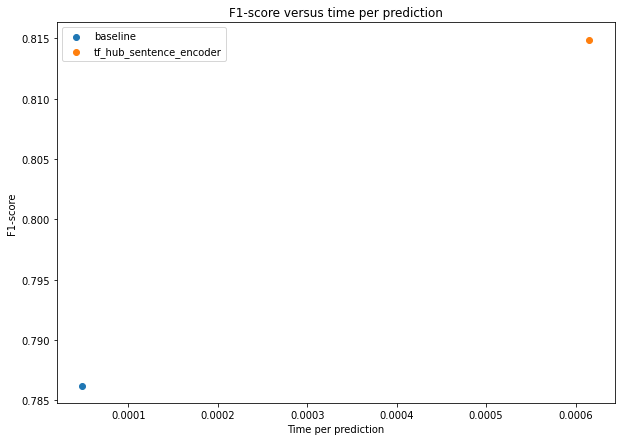

In [141]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label="tf_hub_sentence_encoder")

plt.legend()

plt.title("F1-score versus time per prediction")

plt.xlabel("Time per prediction")
plt.ylabel("F1-score");